## CycleGAN 논문 코드 구현 및 실험

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
from google.colab import drive
import glob
import matplotlib.pyplot as plt
import torchvision

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Layer들 정의

In [ ]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(Block, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias = True, padding_mode = 'reflect'),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self, x):
    return self.conv(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
    super(Discriminator, self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels, features[0], kernel_size = 4, stride = 2, padding = 1, padding_mode ='reflect'), # Conv(3, 64, 4, 2, 1)
    nn.LeakyReLU(0.2))

    layers = []
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(Block(in_channels, feature, stride = 1 if feature == features[-1] else 2)) #Conv(64,128, 4, 2, 1),Conv(128,256, 4, 2, 1), Conv(256, 512, 4, 1, 1)  담는다
      in_channels = feature # 
    layers.append(nn.Conv2d(in_channels,1, kernel_size = 4, stride = 1, padding = 1, padding_mode = 'reflect')) #Conv(512, 1, 4, 1, 1)
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    x = self.initial(x)
    return torch.sigmoid(self.model(x)) # 30 x 30 pathgan

In [ ]:
x = torch.randn((5, 3, 256, 256))
model = Discriminator(in_channels = 3)
preds = model(x)
print(preds.shape)
print(preds[0][0])

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, down = True, use_act = True, **kwargs):
    super(ConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, padding_mode = 'reflect', **kwargs)
        if down else 
        nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace = True) if use_act else nn.Identity()
    )
  def forward(self, x):
    return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
      ConvBlock(channels, channels, kernel_size = 3, padding = 1),
      ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding = 1)
  )
  def forward(self, x):
    return x + self.block(x)

## 생성기 정의

In [ ]:
class Generator(nn.Module):
  def __init__(self, img_channels,num_features = 64, num_resblock = 9):
    super(Generator, self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(img_channels, num_features, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect'),
        nn.ReLU(inplace = True)
    )
    self.down_blocks = nn.ModuleList(
      [
          ConvBlock(num_features, num_features * 2, kernel_size = 3, stride = 2, padding = 1),
       ConvBlock(num_features * 2, num_features * 4, kernel_size = 3, stride = 2, padding = 1),]
    )
    self.residual_block = nn.Sequential(
        *[ResidualBlock(num_features * 4) for _ in range(num_resblock)]
    )

    self.up_blocks = nn.ModuleList(
        [
        ConvBlock(num_features * 4, num_features * 2, down = False, kernel_size = 3, stride = 2,padding = 1, output_padding = 1),
        ConvBlock(num_features * 2, num_features, down = False, kernel_size = 3, stride = 2,padding = 1, output_padding = 1)
    ])
    
    self.last = nn.Conv2d(num_features * 1, img_channels, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect')
  
  def forward(self, x):
    x = self.initial(x)
    for layer in self.down_blocks:
      x = layer(x)
    x= self.residual_block(x)
    for layer in self.up_blocks:
      x = layer(x)
    
    return torch.tanh(self.last(x))

In [ ]:
test = torch.randn(2, 3, 256, 256)
gen = Generator(3)
print(gen(test).shape)

torch.Size([2, 3, 256, 256])


In [ ]:
transforms_ = [transforms.Resize(256),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
test_trans = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 데이터셋은 apple2orange

In [ ]:
class Custom_Dataset(Dataset):
  def __init__(self, root, transforms_ = None, mode = 'train'):
    self.transforms = transforms.Compose(transforms_)
    
    self.file_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*')) 
    self.file_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*'))
  
  def __getitem__(self, index):
    itemA = self.transforms(Image.open(self.file_A[index % len(self.file_A)]))

    itemB = self.transforms(Image.open(self.file_B[index % len(self.file_B)]))

    return {'A' : itemA, 'B' : itemB}

  def __len__(self):
    return max(len(self.file_A), len(self.file_B))  

In [ ]:
root= '/content/drive/MyDrive/apple2orange/apple2orange'
batch_size = 32
learning_rate = 2e-4
lambda_identity = 0
lambda_cycle = 10
num_epochs = 200

In [ ]:
disc_H = Discriminator(in_channels = 3).to(device)
disc_Z = Discriminator(in_channels = 3).to(device)
gen_Z = Generator(img_channels = 3, num_resblock = 9).to(device)
gen_H = Generator(img_channels = 3, num_resblock = 9).to(device)

optim_disc = optim.Adam(list(disc_H.parameters()) + list(disc_Z.parameters()),
                        lr = learning_rate, betas = (0.5, 0.999))
optim_gen = optim.Adam(list(gen_Z.parameters()) + list(gen_H.parameters()),
                       lr = learning_rate, betas = (0.5, 0.999))
L1 = nn.L1Loss()
mse = nn.MSELoss()

In [ ]:
dataset = Custom_Dataset(
     root, transforms_ = transforms_
)
dataloader = DataLoader(dataset, batch_size = 2, shuffle = True)

In [ ]:
imagea = iter(dataloader).next()['A'][1]
imageb = iter(dataloader).next()['B'][1]

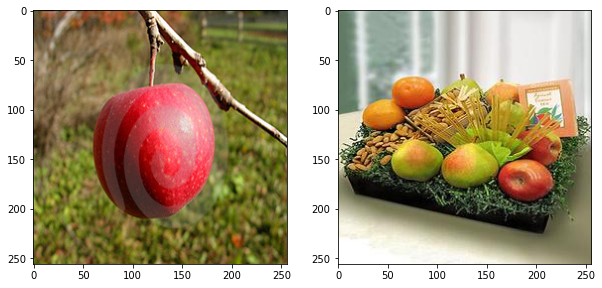

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(imagea, normalize = True).permute(1, 2, 0)) #a에는 사과
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(imageb, normalize = True).permute(1, 2, 0)) #b은 오렌지가 들어있다.

In [ ]:
print(imagea.size())
print(imageb.size())

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
for epoch in range(num_epochs):
  for idx, batch in enumerate(dataloader):
  
    orange = batch['B'].to(device)
    apple = batch['A'].to(device)
    optim_disc.zero_grad()
    optim_gen.zero_grad()

    fake_apple = gen_A(orange) 
    D_A_real = disc_A(horse) 
    D_A_fake = disc_A(fake_horse.detach()) 
    D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))
    D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake)) 
    D_A_loss = D_A_real_loss + D_A_fake_loss 

    fake_orange = gen_O(apple)
    D_O_real = disc_Z(zebra)
    D_O_fake = disc_Z(fake_zebra.detach())
    D_O_real_loss = mse(D_O_real, torch.ones_like(D_O_real))
    D_O_fake_loss = mse(D_O_fake, torch.zeros_like(D_O_fake))
    D_O_loss = D_O_real_loss + D_O_fake_loss

    D_loss = (D_A_loss + D_O_loss) / 2

    D_loss.backward()
    optim_disc.step()
    #generator 학습
    D_A_fake = disc_A(fake_apple)
    D_O_fake = disc_O(fake_orange)
    loss_G_A = mse(D_Z_fake, torch.ones_like(D_A_fake)) #CE 를 쓰지않고 여기서 정의된 새로운 손실함수 
    loss_G_O = mse(D_Z_fake, torch.ones_like(D_O_fake))

    cycle_orange = gen_O(fake_apple)
    cycle_apple = gen_A(fake_orange)
    cycle_orange_loss = L1(orange, cycle_orange)
    cycle_apple_loss = L1(apple, cycle_apple)

    identity_orange = gen_O(orange)
    identity_apple = gen_A(apple)
    identity_orange_loss = L1(orange, identity_orange)
    identity_apple_loss = L1(apple, identity_apple)

    G_loss = (loss_G_O + loss_G_A + cycle_orange_loss * lambda_cycle + cycle_apple_loss * lambda_cycle
              +identity_apple_loss * lambda_identity + identity_orange_loss * lambda_identity)
    G_loss.backward()
    optim_gen.step()
    if idx == 50:
      print('EPOCH : ', epoch, 'G_loss : ', G_loss, 'D_loss :', D_loss)
      break

  

## 모델 저장

In [ ]:
torch.save(gen_A, 'gen_H.pt')
torch.save(gen_O, 'gen_Z.pt')

In [ ]:
apple_image = iter(dataloader).next()['A'][1]
orange_image = iter(dataloader).next()['B'][1]

In [ ]:
apple_image = apple_image.to(device)
orange_image = orange_image.to(device)

## 모델에 이미지 넣어서 결과 확인

## 나름 잘 변환된 것을 확인할 수 있다.

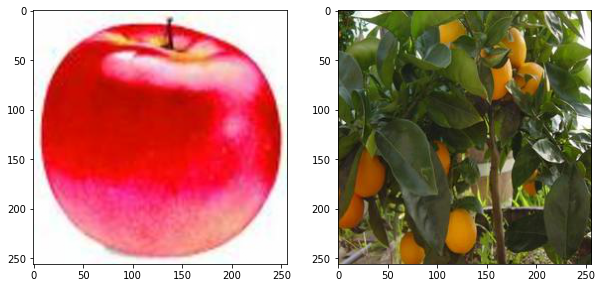

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(apple_image.cpu(), normalize = True).permute(1, 2, 0)) 
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(orange_image.cpu(), normalize = True).permute(1, 2, 0)) 

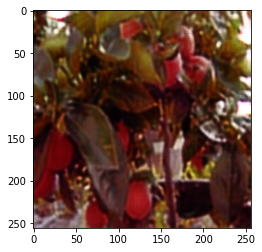

In [ ]:
trans_apple = gen_H(orange_image).cpu()
plt.imshow(torchvision.utils.make_grid(trans_apple.cpu(), normalize = True).permute(1, 2, 0)) 

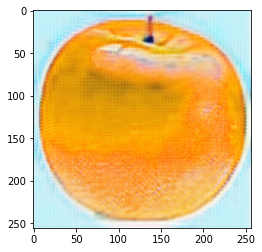

In [ ]:
trans_orange = gen_Z(apple_image).cpu()
plt.imshow(torchvision.utils.make_grid(trans_orange.cpu(), normalize = True).permute(1, 2, 0)) 